In [1]:
import sys
print(sys.version)

3.6.2 (default, Jul 17 2017, 16:44:45) 
[GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]


In [108]:
import shapefile
from collections import namedtuple, Counter, defaultdict
import csv
import matplotlib.pyplot as plt
import codecs
from math import log10

%matplotlib inline

In [3]:
!tree

.
├── data
│   ├── co-est2016-alldata.csv
│   ├── elpo12p010g.dbf
│   ├── elpo12p010g.prj
│   ├── elpo12p010g.sbn
│   ├── elpo12p010g.sbx
│   ├── elpo12p010g.shp
│   ├── elpo12p010g.shx
│   ├── elpo12p010g.txt
│   └── elpo12p010g.xml
└── political-correlation.ipynb

1 directory, 10 files


In [4]:
shp = shapefile.Reader('./data/elpo12p010g')

In [5]:
shp.fields

[('DeletionFlag', 'C', 1, 0),
 ['STATE', 'C', 5, 0],
 ['STATE_FIPS', 'C', 2, 0],
 ['COUNTY', 'C', 254, 0],
 ['FIPS', 'C', 254, 0],
 ['OBAMA', 'N', 16, 6],
 ['ROMNEY', 'N', 16, 6],
 ['OTHERS', 'N', 16, 6],
 ['TTL_VT', 'N', 16, 6],
 ['PCT_OBM', 'N', 16, 6],
 ['PCT_ROM', 'N', 16, 6],
 ['PCT_OTHR', 'N', 16, 6],
 ['WINNER', 'C', 254, 0],
 ['PCT_WNR', 'N', 16, 6],
 ['group', 'N', 4, 0]]

In [6]:
records = shp.records()

In [7]:
records[0]

['AL',
 '01',
 'Autauga',
 '01001',
 6363.0,
 17379.0,
 231.0,
 23973.0,
 26.54236,
 72.494056,
 0.963584,
 'Romney',
 72.494056,
 24]

In [8]:
Row = namedtuple('Row', [field[0].lower() for field in shp.fields[1:]] + ['pop'])

In [9]:
rows = [Row(*(r + [-1])) for r in records]

In [10]:
rows[0]

Row(state='AL', state_fips='01', county='Autauga', fips='01001', obama=6363.0, romney=17379.0, others=231.0, ttl_vt=23973.0, pct_obm=26.54236, pct_rom=72.494056, pct_othr=0.963584, winner='Romney', pct_wnr=72.494056, group=24, pop=-1)

In [11]:
fips2pop = {}
with codecs.open('./data/co-est2016-alldata.csv', encoding='utf-8', errors='ignore') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for i, row in enumerate(reader):
        state_fips, county_fips = row[3:4+1]
        fips = state_fips + county_fips
        fips2pop[fips] = int(row[11])

In [13]:
sum(r.fips in fips2pop for r in rows)/len(rows)

0.9866793529971456

In [14]:
rows[0][:-1]

('AL',
 '01',
 'Autauga',
 '01001',
 6363.0,
 17379.0,
 231.0,
 23973.0,
 26.54236,
 72.494056,
 0.963584,
 'Romney',
 72.494056,
 24)

In [16]:
# I'm sorry this is so gross...
cleaned_rows = [Row(*(list(r[:-1]) + [fips2pop[r.fips]])) for r in rows
                if r.fips in fips2pop]

In [17]:
cleaned_rows[1]

Row(state='AL', state_fips='01', county='Barbour', fips='01005', obama=5912.0, romney=5550.0, others=55.0, ttl_vt=11517.0, pct_obm=51.332812, pct_rom=48.189633, pct_othr=0.477555, winner='Obama', pct_wnr=51.332812, group=12, pop=27132)

We'll make x-axis population size, and y-axis proportion vote republican.

In [18]:
from scipy.stats import describe

In [19]:
describe([r.pop for r in cleaned_rows])

DescribeResult(nobs=3111, minmax=(81, 9953555), mean=100692.10221793635, variance=103110799029.60112, skewness=14.114620251180211, kurtosis=333.09132979383907)

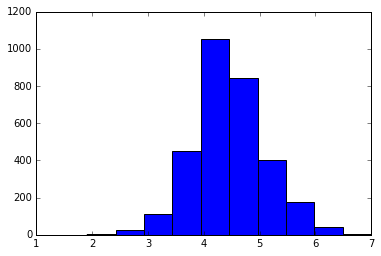

In [26]:
plt.hist([log10(r.pop) for r in cleaned_rows])
plt.show()

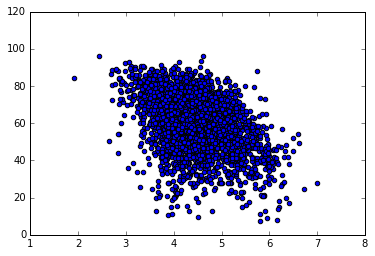

In [27]:
x = [log10(r.pop) for r in cleaned_rows]
y = [r.pct_rom for r in cleaned_rows]
plt.scatter(x, y)
plt.show()

Some more ideas about this scatter...

Can we confidently say that counties whose population size is greater than 1e4 is more likely to vote dem than rep?

Equivalently, are cities more likely to vote dem?

In [34]:
from scipy import stats
import numpy as np

In [42]:
thresh = 1e4
small = [r.pct_rom for r in cleaned_rows if r.pop < thresh]
big = [r.pct_rom for r in cleaned_rows if r.pop >= thresh]
stats.ttest_ind(small, big, equal_var=True)

Ttest_indResult(statistic=12.864742701599715, pvalue=6.1216638226804511e-37)

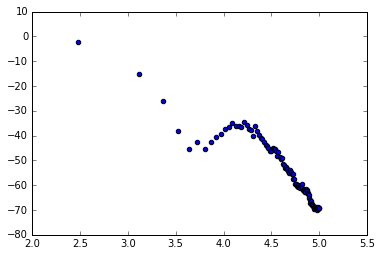

In [60]:
pvals = []
for thresh in np.linspace(300, 1e5, 100):
    # Is there a good datasctructure for this? Maybe it doesn't take the time here...
    small = [r.pct_rom for r in cleaned_rows if r.pop < thresh]
    big = [r.pct_rom for r in cleaned_rows if r.pop >= thresh]
    test = stats.ttest_ind(small, big)
    pvals.append((thresh, test.pvalue))
    

x, y = zip(*pvals)
plt.scatter([log10(t) for t in x], [log10(t) for t in y])
plt.show()

Last but not least, we are curious about the correlation. We could start with linear, but mutual information is a little more robust.

In [64]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

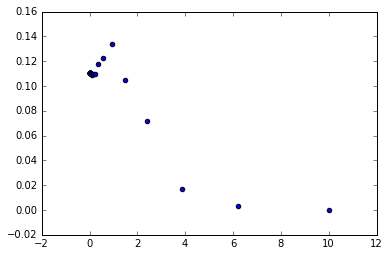

In [82]:
vals = []

for p in np.logspace(-5, 1, 30):
    x = [r.pop**p for r in cleaned_rows]
    y = [r.pct_rom for r in cleaned_rows]
    val = mutual_info_regression(np.reshape(x, (-1, 1)), y)[0]
    vals.append((p, val))

plt.scatter(*zip(*vals))
plt.show()

This leads us to ask, for the previous thresholding experiment were the variances different?

Well of course they would be! Law of small numbers right?

Could that completely explain the lack of high mutual information score, but high statistic that indicates that cities do not vote like towns however one draws the line between cities and towns?

Let's look at the variances over buckets of population sizes.

In [107]:
x = [r.pop for r in cleaned_rows]
y = [r.pct_rom for r in cleaned_rows]
inds = np.digitize(x, bins=np.logspace(2, 7, 10))

In [109]:
buckets = defaultdict(list)
for from_, to_ in enumerate(inds):
    buckets[to_].append(y[from_])

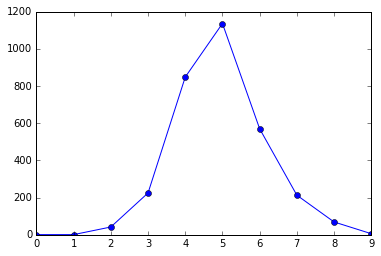

In [117]:
plt.plot([len(buckets[i]) for i in sorted(buckets)], '-o')
plt.show()

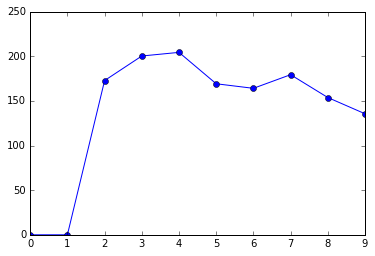

In [118]:
plt.plot([np.var(buckets[i]) for i in sorted(buckets)], '-o')
plt.show()

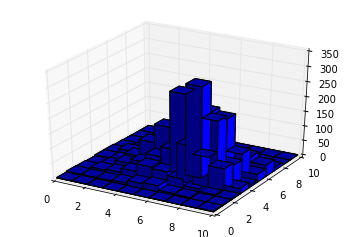

In [125]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

data_2d = [np.histogram(buckets[i])[0] for i in sorted(buckets, reverse=True)]
data_array = np.array(data_2d)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          1, 1, z_data)
plt.show()